In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 10755308.88it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 31669462.44it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 8843127.16it/s]


Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14356087.99it/s]


Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:47,  2.50it/s]                         


Epoch 1 of 100
Generator loss: 1.57467542, Discriminator loss: 0.82058379


118it [00:59,  1.97it/s]                         


Epoch 2 of 100
Generator loss: 3.06936301, Discriminator loss: 1.43097558


118it [01:00,  1.96it/s]                         


Epoch 3 of 100
Generator loss: 5.14900369, Discriminator loss: 0.33704892


118it [00:56,  2.08it/s]                         


Epoch 4 of 100
Generator loss: 2.00918419, Discriminator loss: 1.34736365


118it [00:58,  2.02it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


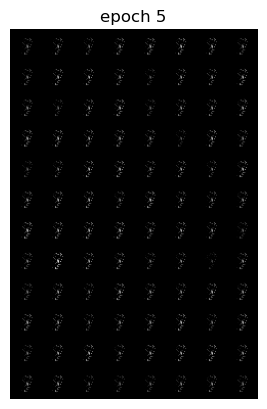

Epoch 5 of 100
Generator loss: 1.06153013, Discriminator loss: 1.25319527


118it [00:57,  2.06it/s]                         


Epoch 6 of 100
Generator loss: 1.64271675, Discriminator loss: 0.95372704


118it [00:58,  2.00it/s]                         


Epoch 7 of 100
Generator loss: 1.86110414, Discriminator loss: 1.18031778


118it [01:01,  1.93it/s]                         


Epoch 8 of 100
Generator loss: 1.99719750, Discriminator loss: 0.80592690


118it [01:01,  1.92it/s]                         


Epoch 9 of 100
Generator loss: 2.04745171, Discriminator loss: 0.86208700


118it [01:02,  1.87it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


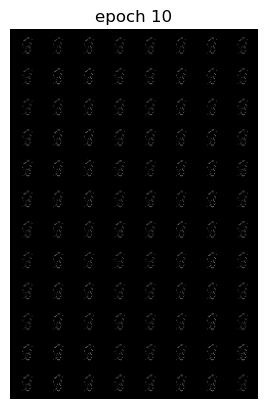

Epoch 10 of 100
Generator loss: 3.48090307, Discriminator loss: 0.93074836


118it [01:01,  1.93it/s]                         


Epoch 11 of 100
Generator loss: 2.57327858, Discriminator loss: 0.83307172


118it [00:58,  2.03it/s]                         


Epoch 12 of 100
Generator loss: 2.47681119, Discriminator loss: 0.86959843


118it [00:56,  2.07it/s]                         


Epoch 13 of 100
Generator loss: 1.81402052, Discriminator loss: 1.05528142


118it [01:00,  1.95it/s]                         


Epoch 14 of 100
Generator loss: 2.58440626, Discriminator loss: 0.64376580


118it [01:02,  1.89it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


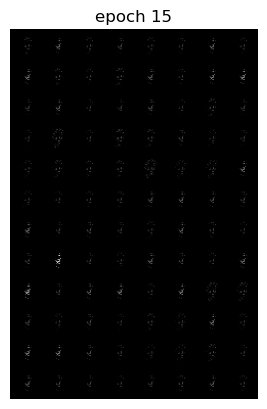

Epoch 15 of 100
Generator loss: 2.19304087, Discriminator loss: 0.82039139


118it [00:57,  2.05it/s]                         


Epoch 16 of 100
Generator loss: 1.67165418, Discriminator loss: 0.89666725


118it [01:03,  1.85it/s]                         


Epoch 17 of 100
Generator loss: 2.07617864, Discriminator loss: 0.76696237


118it [01:00,  1.96it/s]                         


Epoch 18 of 100
Generator loss: 2.71654067, Discriminator loss: 0.53731103


118it [01:03,  1.85it/s]                         


Epoch 19 of 100
Generator loss: 3.21853343, Discriminator loss: 0.40793375


118it [01:06,  1.77it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


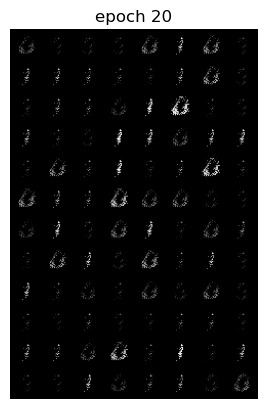

Epoch 20 of 100
Generator loss: 3.11041903, Discriminator loss: 0.47927890


118it [00:59,  1.99it/s]                         


Epoch 21 of 100
Generator loss: 2.96453232, Discriminator loss: 0.64220963


118it [01:04,  1.84it/s]                         


Epoch 22 of 100
Generator loss: 2.45645567, Discriminator loss: 0.55665683


118it [01:03,  1.87it/s]                         


Epoch 23 of 100
Generator loss: 2.07930742, Discriminator loss: 0.63629701


118it [01:01,  1.93it/s]                         


Epoch 24 of 100
Generator loss: 2.86461777, Discriminator loss: 0.54536144


118it [01:00,  1.94it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


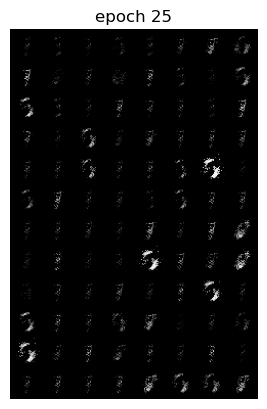

Epoch 25 of 100
Generator loss: 3.11674880, Discriminator loss: 0.47409541


118it [01:11,  1.66it/s]                         


Epoch 26 of 100
Generator loss: 3.04789604, Discriminator loss: 0.53769204


118it [01:01,  1.93it/s]                         


Epoch 27 of 100
Generator loss: 2.69032653, Discriminator loss: 0.53351760


118it [01:00,  1.96it/s]                         


Epoch 28 of 100
Generator loss: 3.24293314, Discriminator loss: 0.38545207


118it [00:53,  2.19it/s]                         


Epoch 29 of 100
Generator loss: 3.59252242, Discriminator loss: 0.30968817


118it [00:53,  2.21it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


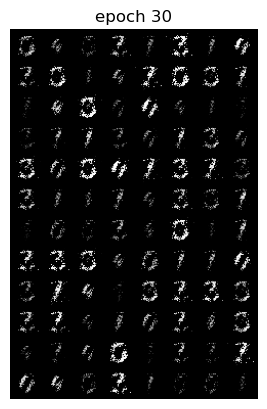

Epoch 30 of 100
Generator loss: 2.98520690, Discriminator loss: 0.48347925


118it [00:53,  2.20it/s]                         


Epoch 31 of 100
Generator loss: 3.32999784, Discriminator loss: 0.49312790


118it [00:56,  2.11it/s]                         


Epoch 32 of 100
Generator loss: 3.11097212, Discriminator loss: 0.43746208


118it [00:53,  2.19it/s]                         


Epoch 33 of 100
Generator loss: 3.19979180, Discriminator loss: 0.46187127


118it [00:53,  2.22it/s]                         


Epoch 34 of 100
Generator loss: 2.88735201, Discriminator loss: 0.58405274


118it [00:52,  2.24it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


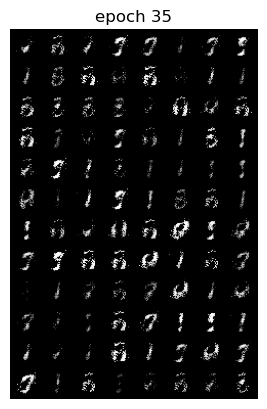

Epoch 35 of 100
Generator loss: 2.99988417, Discriminator loss: 0.50686479


118it [00:52,  2.26it/s]                         


Epoch 36 of 100
Generator loss: 3.12945685, Discriminator loss: 0.54843040


118it [00:52,  2.23it/s]                         


Epoch 37 of 100
Generator loss: 3.10870343, Discriminator loss: 0.52862575


118it [00:51,  2.29it/s]                         


Epoch 38 of 100
Generator loss: 3.00555508, Discriminator loss: 0.54605871


118it [00:51,  2.30it/s]                         


Epoch 39 of 100
Generator loss: 2.82378160, Discriminator loss: 0.52987368


118it [00:51,  2.30it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


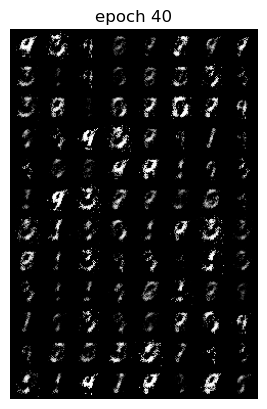

Epoch 40 of 100
Generator loss: 3.46133435, Discriminator loss: 0.38933414


118it [00:51,  2.29it/s]                         


Epoch 41 of 100
Generator loss: 3.14463787, Discriminator loss: 0.49481287


118it [00:51,  2.30it/s]                         


Epoch 42 of 100
Generator loss: 3.13028154, Discriminator loss: 0.47992212


118it [00:50,  2.32it/s]                         


Epoch 43 of 100
Generator loss: 3.08001015, Discriminator loss: 0.47095242


118it [00:55,  2.12it/s]                         


Epoch 44 of 100
Generator loss: 3.07446426, Discriminator loss: 0.48934256


118it [00:54,  2.15it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


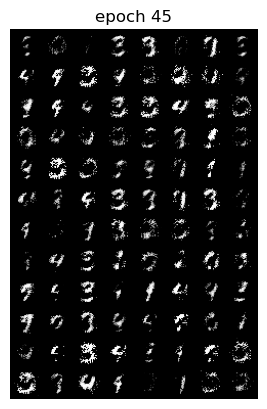

Epoch 45 of 100
Generator loss: 2.80236859, Discriminator loss: 0.62104546


118it [00:53,  2.21it/s]                         


Epoch 46 of 100
Generator loss: 2.59746567, Discriminator loss: 0.60052662


118it [00:56,  2.10it/s]                         


Epoch 47 of 100
Generator loss: 2.98900422, Discriminator loss: 0.52427465


118it [00:51,  2.27it/s]                         


Epoch 48 of 100
Generator loss: 3.06599678, Discriminator loss: 0.51211535


118it [00:53,  2.22it/s]                         


Epoch 49 of 100
Generator loss: 2.86260949, Discriminator loss: 0.59583796


118it [00:56,  2.09it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


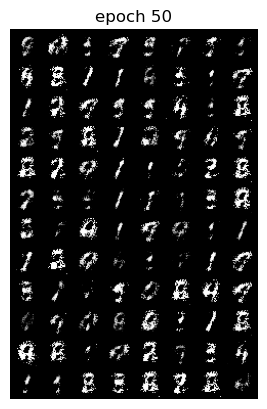

Epoch 50 of 100
Generator loss: 2.97900390, Discriminator loss: 0.56375071


118it [00:53,  2.22it/s]                         


Epoch 51 of 100
Generator loss: 3.01791357, Discriminator loss: 0.48295543


118it [00:52,  2.25it/s]                         


Epoch 52 of 100
Generator loss: 2.88569376, Discriminator loss: 0.53111476


118it [00:56,  2.09it/s]                         


Epoch 53 of 100
Generator loss: 3.03088817, Discriminator loss: 0.49777413


118it [00:59,  2.00it/s]                         


Epoch 54 of 100
Generator loss: 2.94524050, Discriminator loss: 0.51574860


118it [00:55,  2.12it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


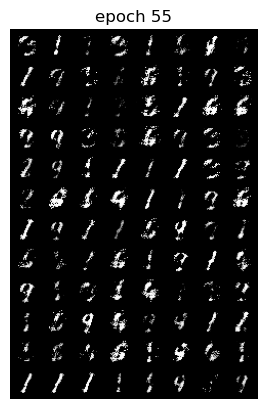

Epoch 55 of 100
Generator loss: 2.90388604, Discriminator loss: 0.55664831


118it [01:01,  1.91it/s]                         


Epoch 56 of 100
Generator loss: 2.96371429, Discriminator loss: 0.52716628


118it [01:05,  1.81it/s]                         


Epoch 57 of 100
Generator loss: 2.99715156, Discriminator loss: 0.52577339


118it [00:58,  2.00it/s]                         


Epoch 58 of 100
Generator loss: 2.97847472, Discriminator loss: 0.54841432


118it [00:56,  2.10it/s]                         


Epoch 59 of 100
Generator loss: 2.60156317, Discriminator loss: 0.62155808


118it [01:01,  1.92it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


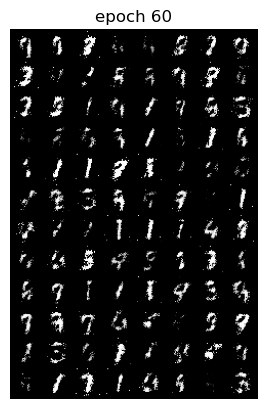

Epoch 60 of 100
Generator loss: 2.79389806, Discriminator loss: 0.54522060


118it [00:52,  2.25it/s]                         


Epoch 61 of 100
Generator loss: 2.68386189, Discriminator loss: 0.59927974


118it [00:51,  2.30it/s]                         


Epoch 62 of 100
Generator loss: 2.79987213, Discriminator loss: 0.53858811


118it [00:52,  2.26it/s]                         


Epoch 63 of 100
Generator loss: 2.58293619, Discriminator loss: 0.59985854


118it [00:52,  2.24it/s]                         


Epoch 64 of 100
Generator loss: 2.53435518, Discriminator loss: 0.61508687


118it [00:52,  2.25it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


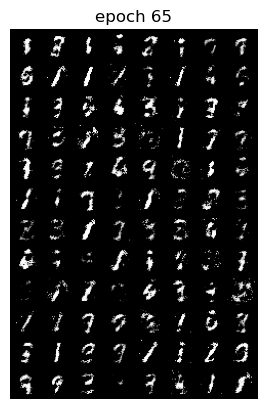

Epoch 65 of 100
Generator loss: 2.66369960, Discriminator loss: 0.57408548


118it [00:53,  2.19it/s]                         


Epoch 66 of 100
Generator loss: 2.44699085, Discriminator loss: 0.61933784


118it [00:54,  2.15it/s]                         


Epoch 67 of 100
Generator loss: 2.47298029, Discriminator loss: 0.62311026


118it [00:53,  2.20it/s]                         


Epoch 68 of 100
Generator loss: 2.39281482, Discriminator loss: 0.65955999


118it [00:52,  2.25it/s]                         


Epoch 69 of 100
Generator loss: 2.28269739, Discriminator loss: 0.71296549


118it [00:51,  2.28it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


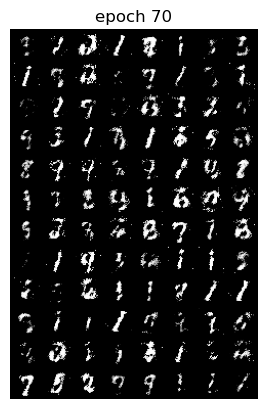

Epoch 70 of 100
Generator loss: 2.30691197, Discriminator loss: 0.68075808


118it [00:52,  2.27it/s]                         


Epoch 71 of 100
Generator loss: 2.48424867, Discriminator loss: 0.64009830


118it [00:52,  2.25it/s]                         


Epoch 72 of 100
Generator loss: 2.62716869, Discriminator loss: 0.65971685


118it [00:53,  2.20it/s]                         


Epoch 73 of 100
Generator loss: 2.20765024, Discriminator loss: 0.67798270


118it [00:55,  2.11it/s]                         


Epoch 74 of 100
Generator loss: 2.27736178, Discriminator loss: 0.67211748


118it [00:56,  2.08it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


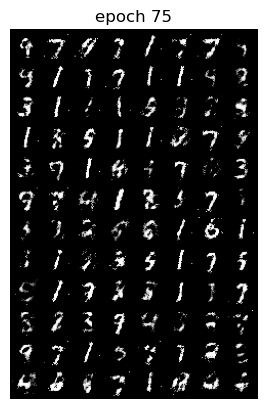

Epoch 75 of 100
Generator loss: 2.23852196, Discriminator loss: 0.71586783


118it [00:57,  2.04it/s]                         


Epoch 76 of 100
Generator loss: 2.12329388, Discriminator loss: 0.73431530


118it [00:56,  2.08it/s]                         


Epoch 77 of 100
Generator loss: 2.05190167, Discriminator loss: 0.74209933


118it [00:52,  2.23it/s]                         


Epoch 78 of 100
Generator loss: 2.12511420, Discriminator loss: 0.73447796


118it [00:53,  2.23it/s]                         


Epoch 79 of 100
Generator loss: 2.16877119, Discriminator loss: 0.71248747


118it [00:53,  2.19it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


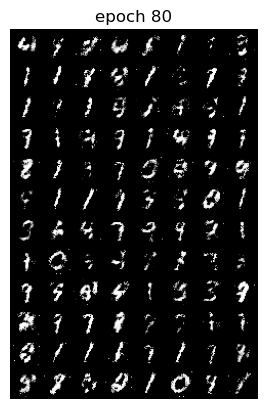

Epoch 80 of 100
Generator loss: 2.13179216, Discriminator loss: 0.72708015


118it [00:54,  2.15it/s]                         


Epoch 81 of 100
Generator loss: 2.32726346, Discriminator loss: 0.69681993


118it [00:54,  2.17it/s]                         


Epoch 82 of 100
Generator loss: 2.16465022, Discriminator loss: 0.72872854


118it [00:56,  2.07it/s]                         


Epoch 83 of 100
Generator loss: 2.17990733, Discriminator loss: 0.71978643


118it [00:55,  2.11it/s]                         


Epoch 84 of 100
Generator loss: 2.10601336, Discriminator loss: 0.75515906


118it [00:54,  2.16it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


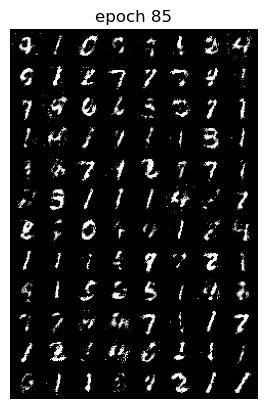

Epoch 85 of 100
Generator loss: 2.25760256, Discriminator loss: 0.68920780


118it [00:52,  2.23it/s]                         


Epoch 86 of 100
Generator loss: 2.24871209, Discriminator loss: 0.72659890


118it [00:53,  2.19it/s]                         


Epoch 87 of 100
Generator loss: 2.13867620, Discriminator loss: 0.73675062


118it [00:54,  2.18it/s]                         


Epoch 88 of 100
Generator loss: 2.18402434, Discriminator loss: 0.71332003


118it [00:58,  2.03it/s]                         


Epoch 89 of 100
Generator loss: 2.23474680, Discriminator loss: 0.73207471


118it [00:53,  2.19it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


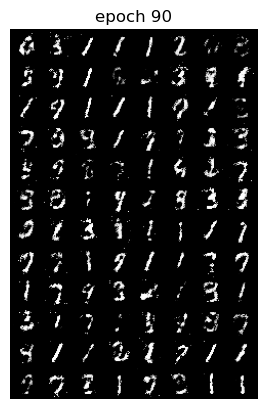

Epoch 90 of 100
Generator loss: 2.14495991, Discriminator loss: 0.75008973


118it [00:52,  2.25it/s]                         


Epoch 91 of 100
Generator loss: 2.00345356, Discriminator loss: 0.74892192


118it [00:53,  2.21it/s]                         


Epoch 92 of 100
Generator loss: 2.01393626, Discriminator loss: 0.79118927


118it [00:54,  2.17it/s]                         


Epoch 93 of 100
Generator loss: 1.95418254, Discriminator loss: 0.77014938


118it [00:53,  2.21it/s]                         


Epoch 94 of 100
Generator loss: 2.05651076, Discriminator loss: 0.75171521


118it [00:52,  2.23it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


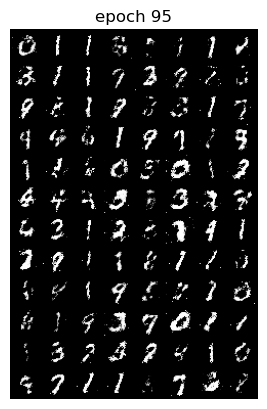

Epoch 95 of 100
Generator loss: 2.19109500, Discriminator loss: 0.72049070


118it [00:52,  2.24it/s]                         


Epoch 96 of 100
Generator loss: 2.26578558, Discriminator loss: 0.72072018


118it [00:52,  2.26it/s]                         


Epoch 97 of 100
Generator loss: 2.06418541, Discriminator loss: 0.73598333


118it [00:50,  2.32it/s]                         


Epoch 98 of 100
Generator loss: 2.07927592, Discriminator loss: 0.75092018


118it [00:52,  2.25it/s]                         


Epoch 99 of 100
Generator loss: 2.01084945, Discriminator loss: 0.74459718


118it [00:53,  2.19it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


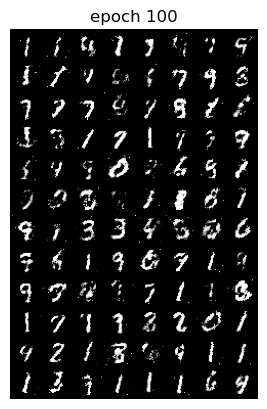

Epoch 100 of 100
Generator loss: 2.06023397, Discriminator loss: 0.74635466


In [14]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    
    return criterion(output, true_label)
    
    
    ######################################
    
def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    
    return criterion(output, true_label)
    
    
    ######################################
    

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        image, _ = data
        image = image.to(device)
        
        true_label = label_real(image.size(0))
        true_output = discriminator(image)
        discriminator_loss_real = discriminator_loss(true_output, true_label)

        noise = create_noise(image.size(0), nz)
        fake_image = generator(noise)
        fake_label = label_fake(image.size(0))
        fake_output = discriminator(fake_image)
        discriminator_loss_fake = discriminator_loss(fake_output, fake_label)  
        dis_loss = discriminator_loss_real + discriminator_loss_fake
        optim_d.zero_grad()
        dis_loss.backward()
        optim_d.step()

        
        noise = create_noise(image.size(0), nz)
        fake_image = generator(noise)
        output = discriminator(fake_image)
        true_label = label_real(image.size(0))
        gen_loss = generator_loss(output, true_label)        
        optim_g.zero_grad()
        gen_loss.backward()
        optim_g.step()

        loss_g += gen_loss.item()
        loss_d += dis_loss.item()
    
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [15]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [16]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

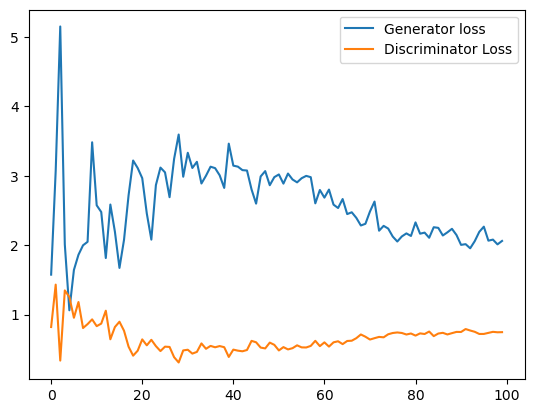

In [17]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')